<a href="https://colab.research.google.com/github/wonjae124/2021_Lab_project/blob/main/Gn_strong_DAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
import torchvision
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import skimage.util.noise as noise 


In [ ]:
# 훈련 데이터, 검증 데이터, 테스트 데이터순으로 5000개, 10000개, 10000개
tr_dataset = datasets.MNIST(root='./data',train=True,download=True,transform=transforms.ToTensor()) 
tr_subset, val_subset = torch.utils.data.random_split(tr_dataset, [50000,10000], generator=torch.Generator().manual_seed(1))
test_set  = torchvision.datasets.MNIST(root='./data', train=False, download=True,transform=transforms.ToTensor())

num_workers= 2
batch_size = 256

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
X_train_set = tr_subset.dataset.data[tr_subset.indices]
Y_train_set = tr_subset.dataset.targets[tr_subset.indices]
X_val_set = val_subset.dataset.data[val_subset.indices]
Y_val_set = val_subset.dataset.targets[val_subset.indices]

train_loader = torch.utils.data.DataLoader(tr_subset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size)

In [ ]:
print(len(train_loader)) # 1epoch당 196개의 minibatch(iteration) update 진행
print(len(valid_loader)) #1epoch당 1epoch당 40개의 미니배치로 val_loss를 측정함. update X

196
40


In [ ]:
train_set_arr = X_train_set.numpy() #numpy 자료형(ndarray) 변환
val_set_arr = X_val_set.numpy()

In [ ]:
#numpy
Gn_strong_train_set_arr = noise.random_noise(X_train_set,mode='gaussian',seed=None, clip=False, mean=0.75) 
Gn_strong_val_set_arr = noise.random_noise(X_val_set,mode='gaussian',seed=None, clip=False, mean=0.75) 

In [ ]:
Gn_strong_train = torch.from_numpy(Gn_strong_train_set_arr).float().div(255.0).unsqueeze(1)
Gn_strong_val = torch.from_numpy(Gn_strong_val_set_arr).float().div(255.0).unsqueeze(1)



Gn_moderate_train = torch.from_numpy(Gn_moderate_train_arr).float().div(255.0).unsqueeze(1)
Gn_moderate_test = torch.from_numpy(Gn_week_val_set_arr).float().div(255.0).unsqueeze(1)

Gn_strong_train = torch.from_numpy(Gn_strong_train_arr).float().div(255.0).unsqueeze(1)
Gn_strong_test = torch.from_numpy(Gn_week_val_set_arr).float().div(255.0).unsqueeze(1)


In [ ]:
Custom_Gn_strong_train = []
for i in range(len(Gn_strong_train)):
  Custom_Gn_strong_train.append([Gn_strong_train[i],Y_train_set[i]])

  
Custom_Gn_strong_train_loader = DataLoader(Custom_Gn_strong_train,batch_size=batch_size)

Custom_Gn_strong_val = []

for i in range(len(Gn_strong_val)):
  Custom_Gn_strong_val.append([Gn_strong_val[i],Y_val_set[i]])
  
Custom_Gn_strong_val_loader = DataLoader(Custom_Gn_strong_val,batch_size=batch_size)

In [ ]:
class Encoder(nn.Module):   

  def __init__(self, encoded_space_dim,fc2_input_dim): 
    super().__init__()

    self.encoder_cnn = nn.Sequential( 
        
        #1, 28, 28 
        nn.Conv2d(in_channels = 1,out_channels = 8,kernel_size = 3, stride = 2, padding = 1),
        #8, 14, 14               #https://machine-geon.tistory.com/46
        nn.ReLU(True), 

         
        nn.Conv2d(in_channels = 8,out_channels = 16,kernel_size = 3, stride=2, padding = 1), 
        #16, 7, 7
        nn.BatchNorm2d(16), 
        nn.ReLU(True),
        
        nn.Conv2d(in_channels = 16,out_channels = 32,kernel_size = 3, stride=2, padding=0),
        #32, 3, 3
        nn.ReLU(True)
    )

    self.flatten = nn.Flatten(start_dim=1) 
    # 32 X 3 X 3 -> v

    self.encoder_lin = nn.Sequential( 
        nn.Linear(3*3*32,fc2_input_dim), #288 -> 128
        nn.ReLU(True),
        nn.Linear(fc2_input_dim, encoded_space_dim) #128->4 
    )

  def forward(self, x): #출력
    x = self.encoder_cnn(x) 
    x = self.flatten(x)
    x = self.encoder_lin(x)
    return x

In [ ]:
class Decoder(nn.Module): 
                          
  def __init__(self, encoded_space_dim, fc2_input_dim):
    super().__init__() 
    self.decoder_lin = nn.Sequential( 
        nn.Linear(encoded_space_dim, fc2_input_dim), #4 -> 128
        nn.ReLU(True),
        nn.Linear(fc2_input_dim, 3*3*32), #128 -> 256 
        nn.ReLU(True)
    )

    self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32,3,3))
     # 256 -> 32,3,3    
    self.decoder_conv = nn.Sequential(  
        nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = 3,
        stride=2, output_padding=0),
         #16,7,7 
        nn.BatchNorm2d(16),
        nn.ReLU(True),

        nn.ConvTranspose2d(in_channels = 16, out_channels = 8, kernel_size=3, 
       stride= 2, padding=1, output_padding=1), 
       #8, 14, 14
        nn.BatchNorm2d(8),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels = 8, out_channels =1,  kernel_size = 3,
        stride=2, padding=1, output_padding=1)  
        #1, 28, 28
    )
     
  def forward(self, x): 
    x = self.decoder_lin(x)
    x = self.unflatten(x)
    x = self.decoder_conv(x)
    x = torch.sigmoid(x) #마지막에 sigmoid를 넣어서 원래의 이미지로 복원한다.
    return x  

In [ ]:
lr = 0.001
torch.manual_seed(0) #manual_seed로 랜덤 난수를 고정함.
d=4

encoder = Encoder(encoded_space_dim=d, fc2_input_dim=128) #처음에 4차원으로 세팅함. 32,1,28,28로 입력값으로 입력시킬 예정이다. [batch,channel.height,width] 
decoder = Decoder(encoded_space_dim=d, fc2_input_dim=128) 

In [ ]:
loss_fn = torch.nn.MSELoss()

params_to_optimize = [ 
  {'params' : encoder.parameters()},  #모델마다 각각의 learning_rate를 설정 
  {'params' : decoder.parameters()}   
]

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 
print('Selected device : {%s}' % device)

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05) 
#weight_decay는 overfitiing 방지 용도임. 최적화 할 때 L2 penalty를 부여해서 loss를 최소화 한다.(Lasso 정규화 참고) 

encoder.to(device) 
decoder.to(device) 

Selected device : {cuda}


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
def AE_train_epoch_den(encoder,decoder, device, dataloader,dataloader_hat,loss_fn, optimizer):
  encoder.train() 
  decoder.train()
  train_loss = [] 
  
  for i,(origin,noisy) in enumerate(zip(dataloader,dataloader_hat)):
    origin_img,_ = origin 
    corrupted_img,_ = noisy

    origin_img = origin_img.to(device)
    corrupted_img=corrupted_img.to(device)

    encoded_data = encoder(corrupted_img)
    decoded_data = decoder(encoded_data)
    loss = loss_fn(decoded_data, origin_img)

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step()

    print('\t partial train loss (single batch):f'%(loss.data)) 
    train_loss.append(loss.detach().cpu().numpy())              
    # 현재 epoch에서의 손실율을 반환한다.
    # loss는 GPU상의 tensor. detach로 그래프(역전파 계산이 끝난 연산기록)에서 분리한 tensor 반환
    # (loss에서 따온)GPU메모리에 올려져 있는 tensor를 cpu 메모리에 복사
    # tesnor를 numpy로 변환시키기 위해서는 cpu 메모리에 존재해야 하므로 .순서상 cpu()>.numpy()이다.
    # (cpu에 복사된)tensor를 numpy로 변환해서 반환 시킨다.(cpu tensor와 numpy array는 저장공간을 공유하는 장점. Gpu tensor는 공유 하지 않음)
    
                                                            
                                                            
  return np.mean(train_loss)


In [ ]:
def AE_test_epoch_den(encoder, decoder, device, dataloader,dataloader_hat,loss_fn):
    encoder.eval() #train 하지 않고 대신에 evaluation mode사용. 테스트 데이터만 가지고 비교 할 것이기 때문임
    decoder.eval() 
    with torch.no_grad(): #with을 써서 gradient 계산을 막아준다.(required_grad=False와 같음). 학습을 하지 않기 때문에 no.grad()일 수 있다.
      conc_out = [] #리스트 자료형 가져옴 
      conc_label = []
      for i,(origin,noisy) in enumerate(zip(dataloader,dataloader_hat)):
        origin_img,_ = origin 
        corrupted_img,_ = noisy
        origin_img = origin_img.to(device)
        corrupted_img=corrupted_img.to(device)    
      
        encoded_data = encoder(corrupted_img)
        decoded_data = decoder(encoded_data)
        
        conc_out.append(decoded_data.cpu()) #decoded_data를 cpu 메모리에 복사하고 이 값을 conc_out 변수에 객체를 추가한다. 
        conc_label.append(origin_img.cpu())  #원본이미지를 conc_label에 추가시켜준다. 쿠다에서 복사해온다.
                                              #문자열 추가함수 append이다. 텐서의 차원을 추가하려면 cat을 쓴다.

      conc_out = torch.cat(conc_out) #concatenate(텐서를 결합하는 함수)다. 반환은 당연히 텐서다. 차원증가와 함께 실제 값이 추가 된다. dim=0이 default이다.
      conc_label = torch.cat(conc_label)

      val_loss = loss_fn(conc_out, conc_label) # loss 비교는 원본이미지 
    return val_loss.data #val_loss반환값이 test_epoch_den 함수인지 아니면 torch.no_grad()함수인지 모르겠다

In [ ]:
def plot_ae_outputs_den(encoder, decoder, n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_set.targets.numpy() 
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}    
    for i in range(n):
      
      ax = plt.subplot(3,n,i+1)
      img = test_set[t_idx[i]][0].unsqueeze(0)     
      Noisy_image_arr = noise.random_noise(img,mode='gaussian',seed=None, clip=True,mean=0.75)
      Noisy_image = torch.from_numpy(Noisy_image_arr).float().div(255.0)
      torch.reshape(Noisy_image, (1,28,28))
      Noisy_image = Noisy_image.to(device)
      img = img.to(device)

      encoder.eval()
      decoder.eval()

      with torch.no_grad():
         rec_img  = decoder(encoder(Noisy_image))

      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(Noisy_image.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Corrupted images')

      ax = plt.subplot(3, n, i + 1 + n + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2: # 나누기 후 소수점 부분을 버린다.
         ax.set_title('Reconstructed images')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()

In [ ]:
##Training Cycle
num_epochs = 25
history_da = {'train_loss':[], 'val_loss':[]}
print(history_da)

{'train_loss': [], 'val_loss': []}


EPOCH 1/25
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	

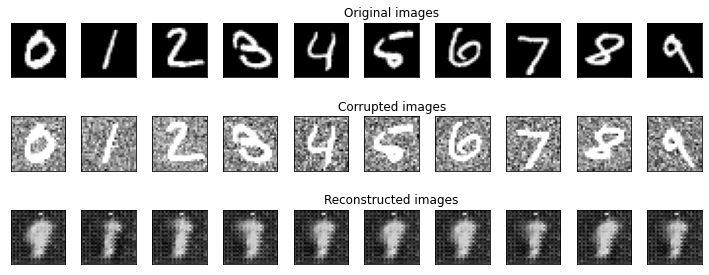

EPOCH 2/25
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	

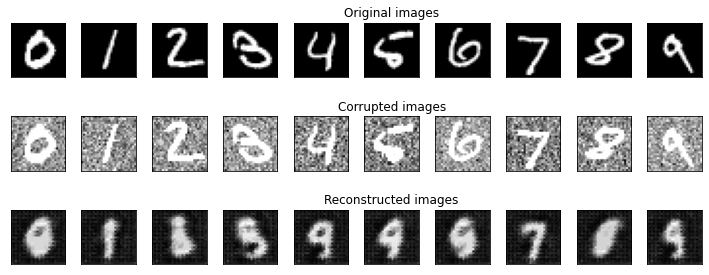

EPOCH 3/25
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	

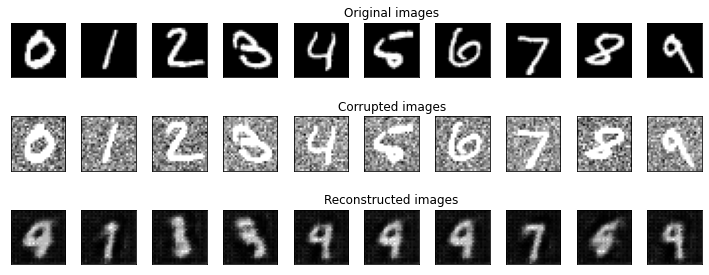

EPOCH 4/25
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	

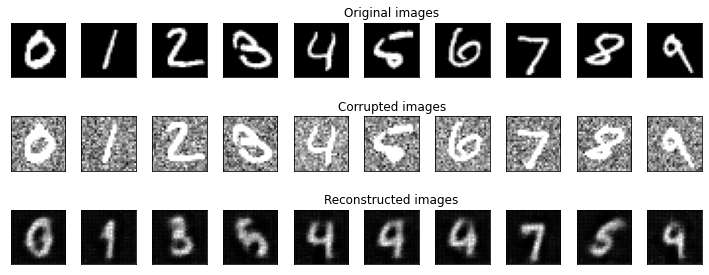

EPOCH 5/25
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	

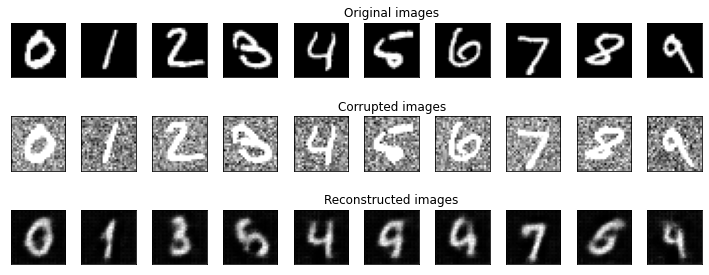

EPOCH 6/25
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	

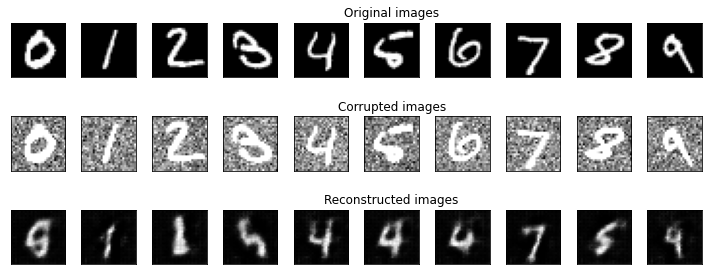

EPOCH 7/25
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	

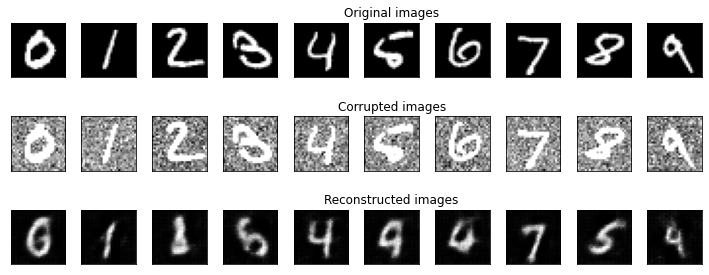

EPOCH 8/25
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	

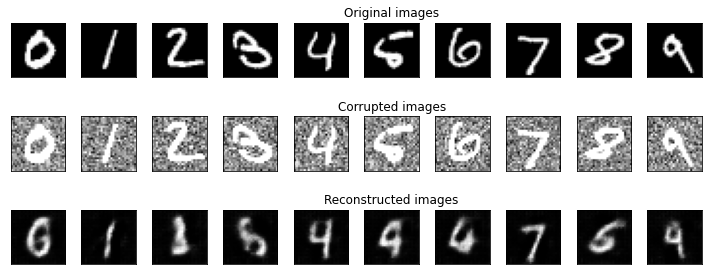

EPOCH 9/25
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	

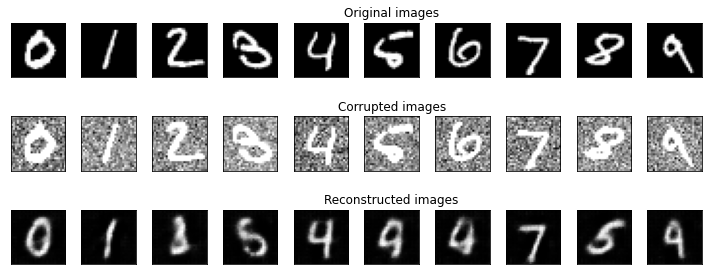

EPOCH 10/25
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f


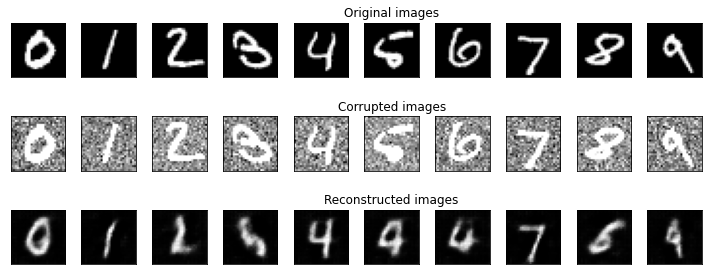

EPOCH 11/25
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f


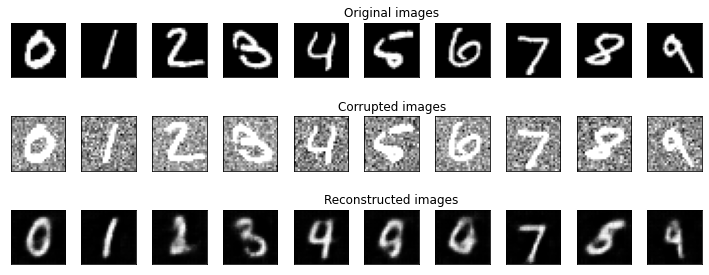

EPOCH 12/25
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f


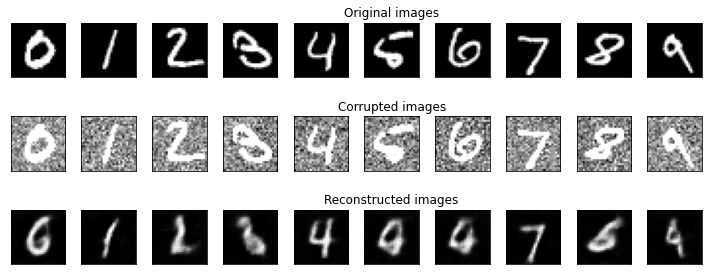

EPOCH 13/25
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f


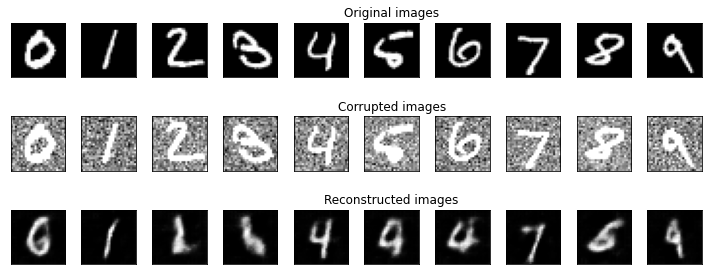

EPOCH 14/25
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f


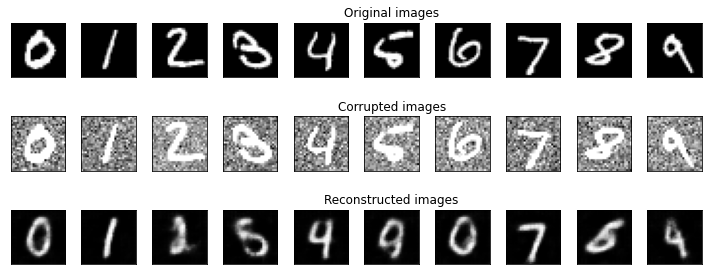

EPOCH 15/25
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f


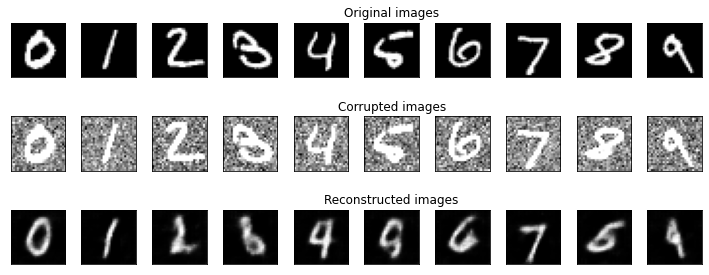

EPOCH 16/25
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f


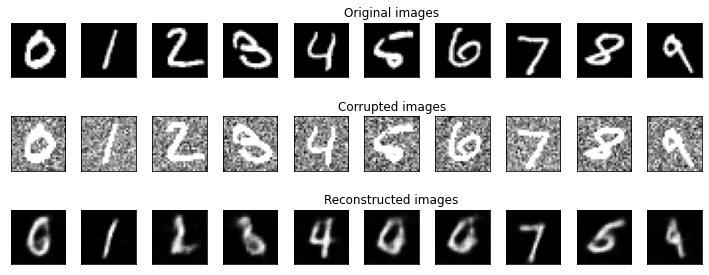

EPOCH 17/25
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f


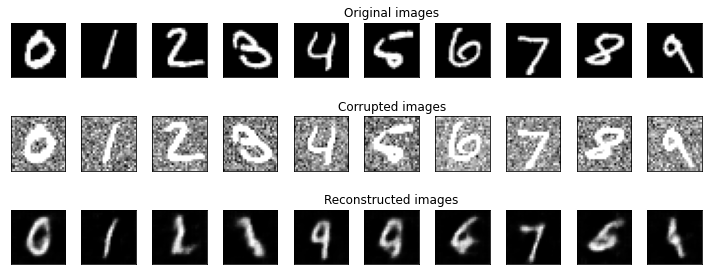

EPOCH 18/25
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f


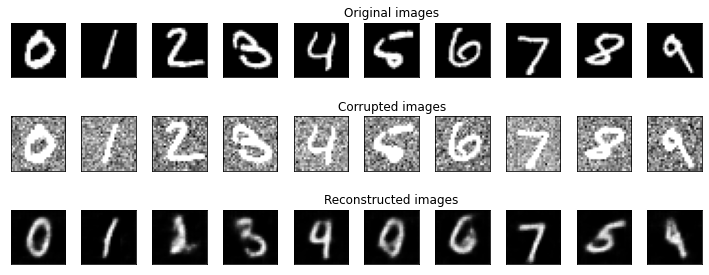

EPOCH 19/25
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f


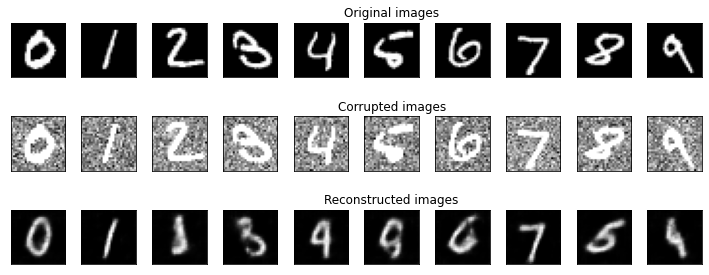

EPOCH 20/25
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f


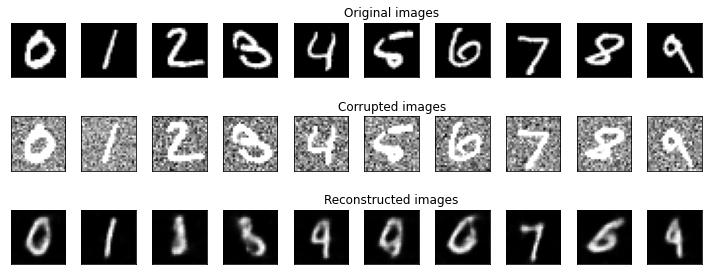

EPOCH 21/25
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f


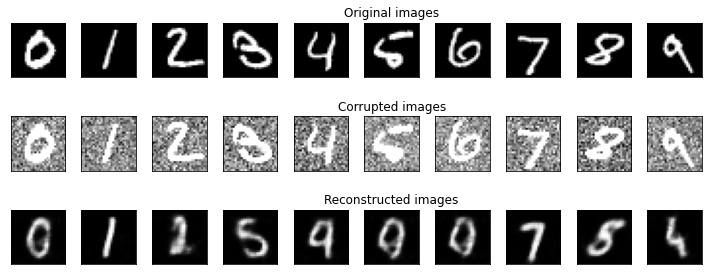

EPOCH 22/25
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f


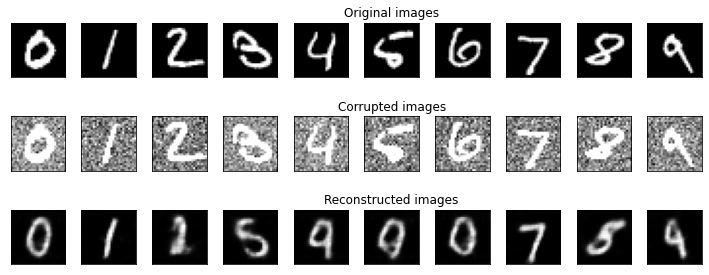

EPOCH 23/25
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f


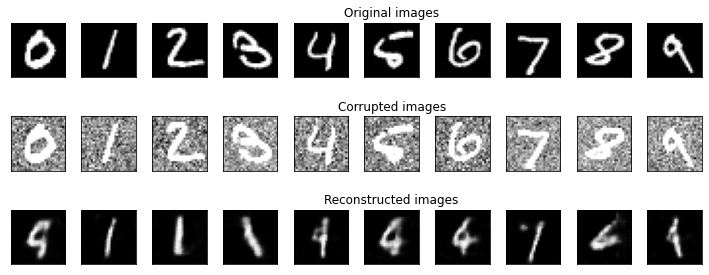

EPOCH 24/25
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f


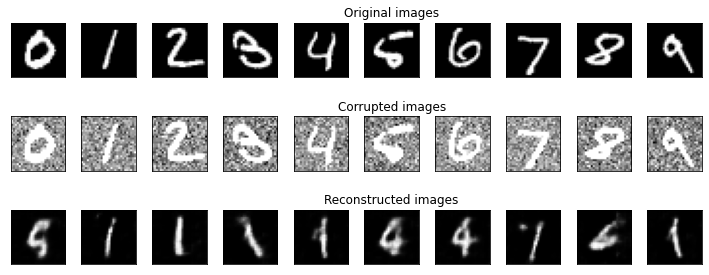

EPOCH 25/25
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f
	 partial train loss (single batch):f


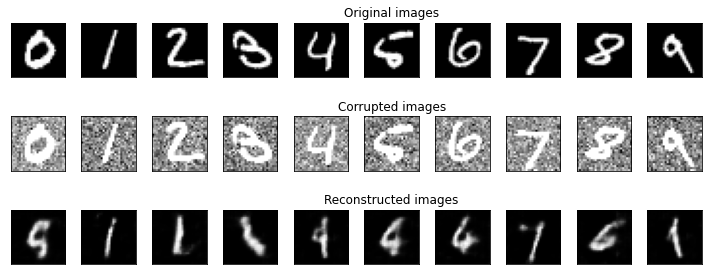

In [ ]:
for epoch in range(num_epochs): #training하면서 몇 번의 epoch때 마다 검증데이터로 오차율?을 계산한다. 실제로 보정까지 하는지는 확인필요??
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss=AE_train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device,
        dataloader=train_loader, 
        dataloader_hat=Custom_Gn_strong_train_loader,
        loss_fn=loss_fn, 
        optimizer=optim) 

  
    val_loss = AE_test_epoch_den( 
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=valid_loader, 
        dataloader_hat=Custom_Gn_strong_val_loader,
        loss_fn=loss_fn) #여기도 noise_factor 변경 필요
    # Print Validationloss
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)

    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    plot_ae_outputs_den(encoder, decoder)

In [ ]:
#After training
AE_test_epoch_den(encoder, decoder, device, dataloader,dataloader_hat, loss_fn).item()

NameError: ignored